INFO:__main__:Creating temporal features...
INFO:__main__:Temporal features created successfully


Step 1: Creating Temporal Features


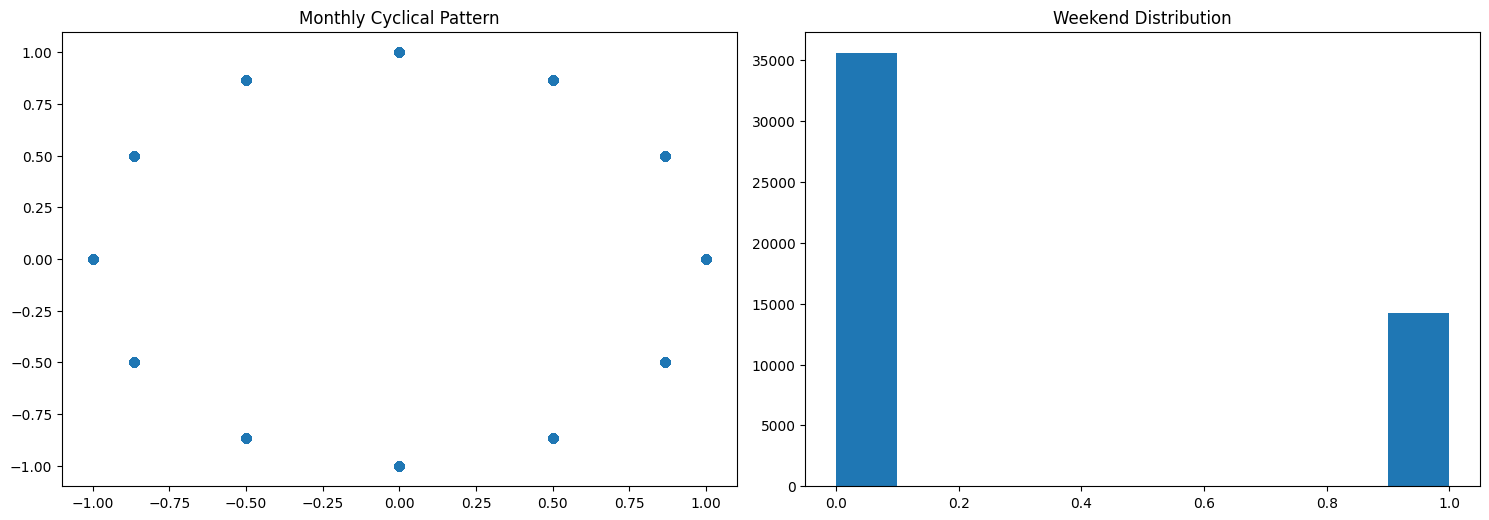

INFO:__main__:Creating customer segments...



Step 2: Creating Customer Segments


INFO:__main__:Customer segments created successfully



Customer Segmentation Summary:
--------------------------------------------------

InvoiceNo Segments:
InvoiceNo_Segment
Medium    15006
High      14911
Low       14887
Name: count, dtype: int64

Total Amount Segments:
TotalAmount_Segment
Medium    15006
High      14911
Low       14887
Name: count, dtype: int64


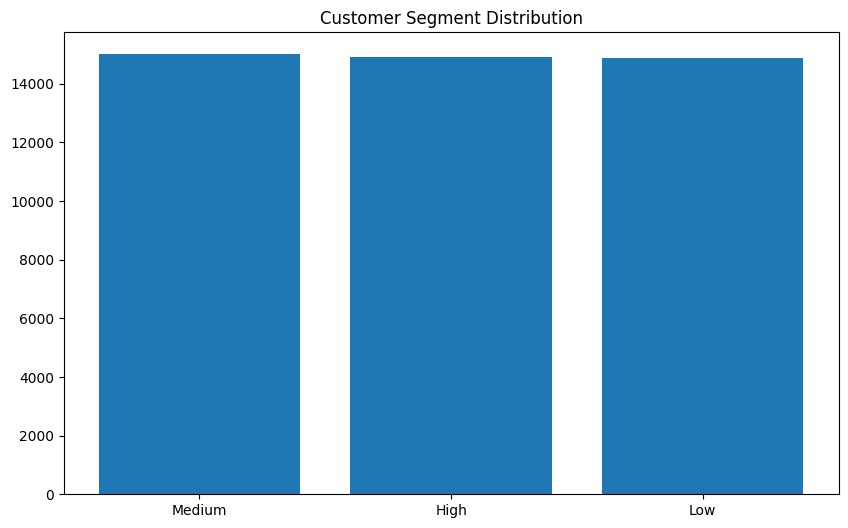

INFO:__main__:Processing product categories...
INFO:__main__:Product categories processed successfully
INFO:__main__:Processing geographic markets...
INFO:__main__:Geographic markets processed successfully
INFO:__main__:Creating target variable at daily level...
INFO:__main__:Target variable created successfully



Step 3: Processing Product Categories

Step 4: Handling Geographic Markets

Step 5: Creating Target Variables

Preprocessing Summary:
--------------------------------------------------
Total features created: 36
Time period covered: 2020-01-01 to 2025-09-05

Feature categories created:
- Temporal features
- Customer segments
- Product categories
- Geographic features
- Target variables

Sample of processed features:
   InvoiceNo StockCode Description  Quantity         InvoiceDate  UnitPrice  CustomerID         Country  Discount  PaymentMethod  ShippingCost     Category SalesChannel  ReturnStatus ShipmentProvider WarehouseLocation OrderPriority  TotalAmount  Year  Month  DayOfWeek  Hour  Month_sin  Month_cos  DayOfWeek_sin  DayOfWeek_cos  Hour_sin  Hour_cos  IsWeekend InvoiceNo_Segment TotalAmount_Segment ValueSegment MarketSize  Country_encoded  MarketSize_encoded        Date
0     221958  SKU_1964   White Mug        38 2020-01-01 00:00:00       1.71     37039.0       Australia  0.470

In [2]:
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import plotly.graph_objs as go
import plotly.subplots as sp
import warnings
import os
import logging
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load data
analyzed_file = max(
    [f for f in os.listdir('/Users/pavankakarrot/Documents/retail_forecasting/data/processed') if 'data_explored' in f],
    key=lambda x: os.path.getctime(os.path.join('/Users/pavankakarrot/Documents/retail_forecasting/data/processed', x))
)
df = pd.read_csv(f'/Users/pavankakarrot/Documents/retail_forecasting/data/processed/retail_data_quality_assessed_20241130_1822.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

class RetailPreprocessor:
    """
    A comprehensive preprocessor for retail sales data.
    Handles temporal features, customer segmentation, and target variable creation.
    """
    def __init__(self, df):
        self.df = df.copy()
        self.logger = logging.getLogger(__name__)
        self.customer_segments = None
        self.product_categories = None
        
        # Calculate TotalAmount if it doesn't exist
        if 'TotalAmount' not in self.df.columns:
            self.df['TotalAmount'] = self.df['Quantity'] * self.df['UnitPrice']
            
    def create_temporal_features(self):
        """Create time-based features for forecasting."""
        self.logger.info("Creating temporal features...")
        
        # Ensure datetime
        self.df['InvoiceDate'] = pd.to_datetime(self.df['InvoiceDate'])
        
        # Extract basic time components
        self.df['Year'] = self.df['InvoiceDate'].dt.year
        self.df['Month'] = self.df['InvoiceDate'].dt.month
        self.df['DayOfWeek'] = self.df['InvoiceDate'].dt.dayofweek
        self.df['Hour'] = self.df['InvoiceDate'].dt.hour
        
        # Create cyclical features
        self.df['Month_sin'] = np.sin(2 * np.pi * self.df['Month']/12)
        self.df['Month_cos'] = np.cos(2 * np.pi * self.df['Month']/12)
        self.df['DayOfWeek_sin'] = np.sin(2 * np.pi * self.df['DayOfWeek']/7)
        self.df['DayOfWeek_cos'] = np.cos(2 * np.pi * self.df['DayOfWeek']/7)
        self.df['Hour_sin'] = np.sin(2 * np.pi * self.df['Hour']/24)
        self.df['Hour_cos'] = np.cos(2 * np.pi * self.df['Hour']/24)
        
        # Create weekend indicator
        self.df['IsWeekend'] = self.df['DayOfWeek'].isin([5, 6]).astype(int)
        
        self.logger.info("Temporal features created successfully")
        return self
        
    def create_customer_segments(self, n_segments=3):
        """
        Create customer segments based on RFM (Recency, Frequency, Monetary) analysis.
         Handles duplicate values and ensures proper column creation.
        """
        self.logger.info("Creating customer segments...")
    
        # Calculate customer metrics
        customer_metrics = self.df.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (x.max() - x.min()).days,  # Customer lifespan
            'InvoiceNo': 'count',  # Frequency
            'TotalAmount': 'sum'   # Monetary value
        }).reset_index()
    
        # Create segments using a simpler approach
        for column in ['InvoiceNo', 'TotalAmount']:
            # Sort values and assign segments
            sorted_values = customer_metrics[column].sort_values()
            segment_size = len(sorted_values) // n_segments
        
            # Create segment labels
            labels = np.repeat('Medium', len(sorted_values))
            labels[:segment_size] = 'Low'
            labels[-segment_size:] = 'High'
        
            # Assign segments
            customer_metrics[f'{column}_Segment'] = labels
    
        # Store customer segments
        self.customer_segments = customer_metrics
    
        # Verify columns exist before merging
        required_columns = ['CustomerID', 'InvoiceNo_Segment', 'TotalAmount_Segment']
        if not all(col in customer_metrics.columns for col in required_columns):
            self.logger.error("Missing required columns in customer metrics")
            print("Available columns:", customer_metrics.columns.tolist())
            raise ValueError("Required columns not found in customer metrics")
    
        # Merge segments back to main DataFrame
        self.df = self.df.merge(
            customer_metrics[required_columns],
            on='CustomerID',
            how='left'
        )
    
        # Print segmentation summary
        print("\nCustomer Segmentation Summary:")
        print("-" * 50)
        print("\nInvoiceNo Segments:")
        print(self.df['InvoiceNo_Segment'].value_counts())
        print("\nTotal Amount Segments:")
        print(self.df['TotalAmount_Segment'].value_counts())
    
        self.logger.info("Customer segments created successfully")
        return self
        
    def process_product_categories(self):
        """
        Process product categories and create product-based features.
        """
        self.logger.info("Processing product categories...")
    
        # Calculate product metrics with proper column handling
        product_metrics = self.df.groupby('StockCode').agg({
            'Quantity': ['sum', 'mean'],
            'UnitPrice': 'mean',
            'TotalAmount': 'sum'
        })
    
        # Flatten the multi-level columns
        product_metrics.columns = ['_'.join(col).strip() for col in product_metrics.columns.values]
        product_metrics = product_metrics.reset_index()
    
        # Create value segments using the flattened TotalAmount column
        product_metrics['ValueSegment'] = pd.qcut(
            product_metrics['TotalAmount_sum'], 
            q=3, 
            labels=['Low', 'Medium', 'High']
        )
    
        # Store product categories
        self.product_categories = product_metrics
    
        # Merge only necessary columns back to main DataFrame
        self.df = self.df.merge(
            product_metrics[['StockCode', 'ValueSegment']], 
            on='StockCode', 
            how='left'
        )
    
        self.logger.info("Product categories processed successfully")
        return self
        
    def handle_geographic_markets(self):
        """Process geographic information."""
        self.logger.info("Processing geographic markets...")
        
        market_metrics = self.df.groupby('Country').agg({
            'TotalAmount': 'sum',
            'CustomerID': 'nunique'
        }).reset_index()
        
        market_metrics['MarketSize'] = pd.qcut(
            market_metrics['TotalAmount'], 
            q=3, 
            labels=['Small', 'Medium', 'Large']
        )
        
        self.df = self.df.merge(
            market_metrics[['Country', 'MarketSize']], 
            on='Country', 
            how='left'
        )
        
        le = LabelEncoder()
        self.df['Country_encoded'] = le.fit_transform(self.df['Country'])
        self.df['MarketSize_encoded'] = le.fit_transform(self.df['MarketSize'])
        
        self.logger.info("Geographic markets processed successfully")
        return self
        
    def create_target_variable(self, agg_level='daily'):
        """Create target variable for forecasting."""
        self.logger.info(f"Creating target variable at {agg_level} level...")
        
        if agg_level == 'daily':
            self.df['Date'] = self.df['InvoiceDate'].dt.date
        elif agg_level == 'weekly':
            self.df['Date'] = self.df['InvoiceDate'].dt.to_period('W').astype(str)
        elif agg_level == 'monthly':
            self.df['Date'] = self.df['InvoiceDate'].dt.to_period('M').astype(str)
            
        sales_data = self.df.groupby('Date').agg({
            'TotalAmount': 'sum',
            'Quantity': 'sum',
            'InvoiceNo': 'count'
        }).reset_index()
        
        sales_data.columns = ['Date', 'Sales', 'Units', 'Transactions']
        
        self.target_data = sales_data
        self.logger.info("Target variable created successfully")
        return self
        
    def get_processed_data(self):
        """Return processed data and targets."""
        return self.df, self.target_data

# Initialize preprocessor and execute pipeline
preprocessor = RetailPreprocessor(df)

# Execute preprocessing steps
print("Step 1: Creating Temporal Features")
preprocessor.create_temporal_features()

# Visualize temporal features
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(preprocessor.df['Month_sin'], preprocessor.df['Month_cos'])
plt.title('Monthly Cyclical Pattern')
plt.subplot(2, 2, 2)
plt.hist(preprocessor.df['IsWeekend'])
plt.title('Weekend Distribution')
plt.tight_layout()
plt.show()

print("\nStep 2: Creating Customer Segments")
preprocessor.create_customer_segments()
plt.figure(figsize=(10, 6))
customer_segment_counts = preprocessor.df['TotalAmount_Segment'].value_counts()
plt.bar(customer_segment_counts.index, customer_segment_counts.values)
plt.title('Customer Segment Distribution')
plt.show()

print("\nStep 3: Processing Product Categories")
preprocessor.process_product_categories()

print("\nStep 4: Handling Geographic Markets")
preprocessor.handle_geographic_markets()

print("\nStep 5: Creating Target Variables")
preprocessor.create_target_variable(agg_level='daily')

# Get processed data
processed_df, target_data = preprocessor.get_processed_data()

# Save results
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
output_dir = '/Users/pavankakarrot/Documents/retail_forecasting/data/processed'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save files
processed_df.to_csv(f'{output_dir}/processed_features_{timestamp}.csv', index=False)
target_data.to_csv(f'{output_dir}/target_data_{timestamp}.csv', index=False)

# Print summary
print("\nPreprocessing Summary:")
print("-" * 50)
print(f"Total features created: {processed_df.shape[1]}")
print(f"Time period covered: {target_data['Date'].min()} to {target_data['Date'].max()}")
print("\nFeature categories created:")
print("- Temporal features")
print("- Customer segments")
print("- Product categories")
print("- Geographic features")
print("- Target variables")

# Display samples
print("\nSample of processed features:")
print(processed_df.head())
print("\nSample of target data:")
print(target_data.head())